In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import laspy
import os
import time


In [103]:

script_dir=os.getcwd()
# 更改当前工作目录
os.chdir(script_dir)
path=os.path.abspath(os.path.join(os.getcwd(), ".."))

def load_data(name):
    
    pathraw=f"..\\data\\bridge-5cls-fukushima\\test\\{name}.txt"
    pathtest=f'log\\sem_seg\\2024-10-05_01-43\\visual\\{name}_pred.txt'
    # 读取数据
    data_raw = np.loadtxt(pathraw, delimiter=' ')
    data_test = np.loadtxt(pathtest, delimiter=' ')

    # 提取床板数据（label == 2）
    deck_raw = data_raw[data_raw[:, 6] == 2]
    deck_test = data_test[data_test[:, 6] == 2]


    # 提取x, y坐标（忽略z坐标）
    deck_raw_coords = deck_raw[:, :2]
    deck_test_coords = deck_test[:, :2]

    print(f"Total points: {data_test.shape[0]}")
    print(f"Deck points_raw: {deck_raw.shape}")
    print(f"Deck points_test: {deck_test.shape}")
    return deck_raw, deck_test

deck_raw, deck_test = load_data('Bridge3_1')
#np.savetxt('log\\sem_seg\\2024-10-05_01-43\\visual\\Bridge3_0_raw_deck.txt', deck_raw, delimiter=' ')

Total points: 1148643
Deck points_raw: (84477, 7)
Deck points_test: (148425, 7)


In [38]:
import laspy

# 分离各列数据
x, y, z, r, g, b, label =  deck_test.T

r_16bit = (r * 65535).astype(np.uint16)
g_16bit = (g * 65535).astype(np.uint16)
b_16bit = (b * 65535).astype(np.uint16)

# 创建LAS文件
las = laspy.create(file_version="1.3", point_format=3)

# 设置头部信息
las.header.offsets = [np.min(x), np.min(y), np.min(z)]
las.header.scales = [0.001, 0.001, 0.001]

# 写入点数据
las.x = x
las.y = y
las.z = z
las.red = r_16bit
las.green = g_16bit
las.blue = b_16bit
las.classification  = label.astype(np.uint8)

# 保存LAS文件
las.write('output-deck-test.las')

print("LAS文件已创建：output-deck-test.las")

LAS文件已创建：output-deck-test.las


# Denoise

In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

def dbscan_convex_hull(data, eps=0.5, min_samples=10):
 
    bridge_points = data[:, :3]
    
    # 应用DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(bridge_points)
    
    # 找到最大的聚类
    unique_labels, counts = np.unique(clustering.labels_, return_counts=True)
    largest_cluster = unique_labels[np.argmax(counts[1:])+1]  # 忽略噪声(-1)
    
    # 提取最大聚类的点
    largest_cluster_points = bridge_points[clustering.labels_ == largest_cluster]
    
    # 计算凸包
    hull = ConvexHull(largest_cluster_points)
    
    # 返回凸包顶点
    return largest_cluster_points[hull.vertices]

# 使用示例
result = dbscan_convex_hull(deck_test,0.5,100)

# 可视化
plot_deck(result,'DBSCAN')

NameError: name 'plot_deck' is not defined

In [7]:
def test(data):
    bridge_points = data[:, :3]

    # 体素网格滤波
    voxel_size=0.1
    voxel_coords = np.floor(bridge_points / voxel_size).astype(int)
    _, unique_indices = np.unique(voxel_coords, axis=0, return_index=True)
    filtered_points = bridge_points[unique_indices]
    print(f"Voxel grid filtering: {filtered_points.shape}")
    print(f"bridge_points: {bridge_points.shape}")

test(deck_test)
         

Voxel grid filtering: (9602, 3)
bridge_points: (84129, 3)


In [1]:
from sklearn.linear_model import RANSACRegressor


def data_voxel(data, voxel_size=0.1):

    bridge_points = data[:, :3]
    
    # 体素网格滤波
    voxel_coords = np.floor(bridge_points / voxel_size).astype(int)
    _, unique_indices = np.unique(voxel_coords, axis=0, return_index=True)
    filtered_points = bridge_points[unique_indices]
    
    return filtered_points

def ransac_plane_fitting(data, max_trials=1000, residual_threshold=0.1):
    
    bridge_points = data[:, :3]
    
    # 使用RANSAC拟合平面
    ransac = RANSACRegressor(max_trials=max_trials, residual_threshold=residual_threshold, random_state=42)
    ransac.fit(bridge_points[:, :2], bridge_points[:, 2])
    
    # 获取内点
    inlier_mask = ransac.inlier_mask_
    
    return bridge_points[inlier_mask]


def dbscan_outlier_removal(points, eps=0.5, min_samples=5):
    import numpy as np
    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler
    # 标准化数据
    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(points)

    # 应用DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(points_scaled)

    # 识别非离群点（即被分配到簇中的点）
    inliers = points[clusters != -1] # -1 表示离群点
    outliers = points[clusters == -1]

    return inliers




def lof_outlier_removal(points, n_neighbors=20, contamination='auto'):
    from sklearn.neighbors import LocalOutlierFactor
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outlier_labels = lof.fit_predict(points)
    
    inliers = points[outlier_labels == 1]
    
    return inliers



def isolation_forest_outlier_removal(points, contamination=0.1):
    from sklearn.ensemble import IsolationForest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_labels = iso_forest.fit_predict(points)
    
    inliers = points[outlier_labels == 1]
    outliers = points[outlier_labels == -1]
    
    return inliers

# 可视化
def plot_deck(coords, title):
    plt.figure(figsize=(8, 12))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.1, s=1)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()



deck_raw, deck_test = load_data('Bridge3_1')

start_time = time.time()

result = deck_test

result = data_voxel(result, voxel_size=0.005)

result = ransac_plane_fitting(result,2000,0.02)

result = isolation_forest_outlier_removal(result, contamination=0.3)

result = lof_outlier_removal(result, n_neighbors=10, contamination=0.4)

result = dbscan_outlier_removal(result,eps=1,min_samples=3)

end_time = time.time()

result_raw = deck_raw

width_raw, length_raw = calculate_bridge_dimensions(result_raw)
print(f"原始的桥板宽度-x: {width_raw:.2f}")
print(f"原始的桥板长度-Y: {length_raw:.2f}")

# 假设 ransac_inliers 是RANSAC提取的平面内点
width, length = calculate_bridge_dimensions(result)
print(f"估计的桥板宽度-x: {width:.2f}")
print(f"估计的桥板长度-Y: {length:.2f}")

# 可视化
print(f"Time: {end_time - start_time:.2f} s")
plot_deck(result,'RANSAC')


NameError: name 'load_data' is not defined

Total points: 892875
Deck points_raw: (97462, 7)
Deck points_test: (147068, 7)
原始的桥板长度: 10.01
原始的桥板宽度: 5.55
估计的桥板长度: 10.29
估计的桥板宽度: 5.12
Time: 0.84 s


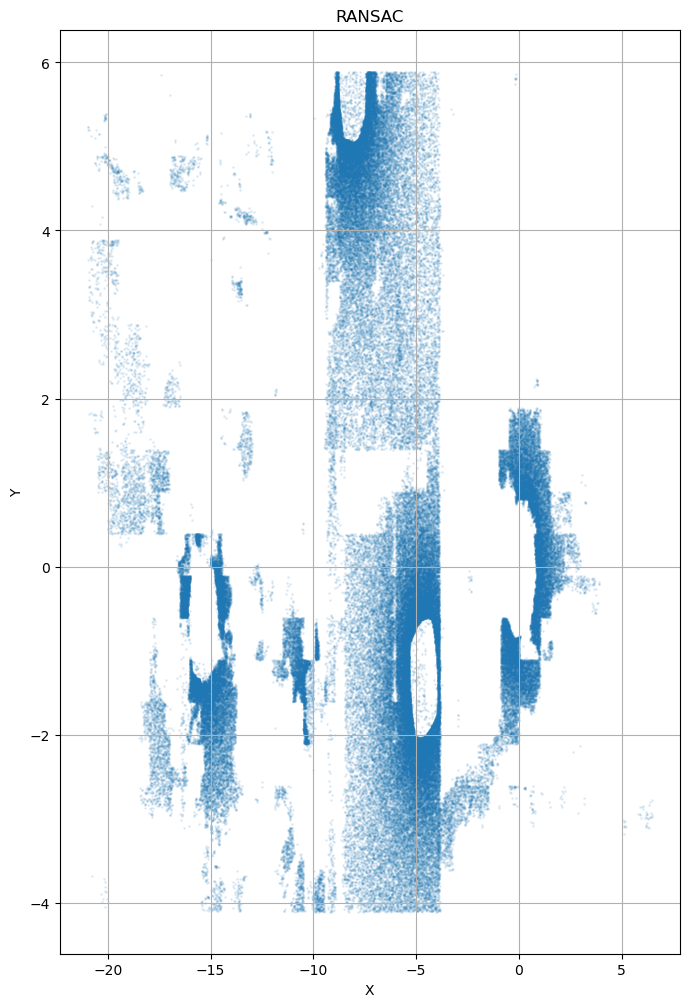

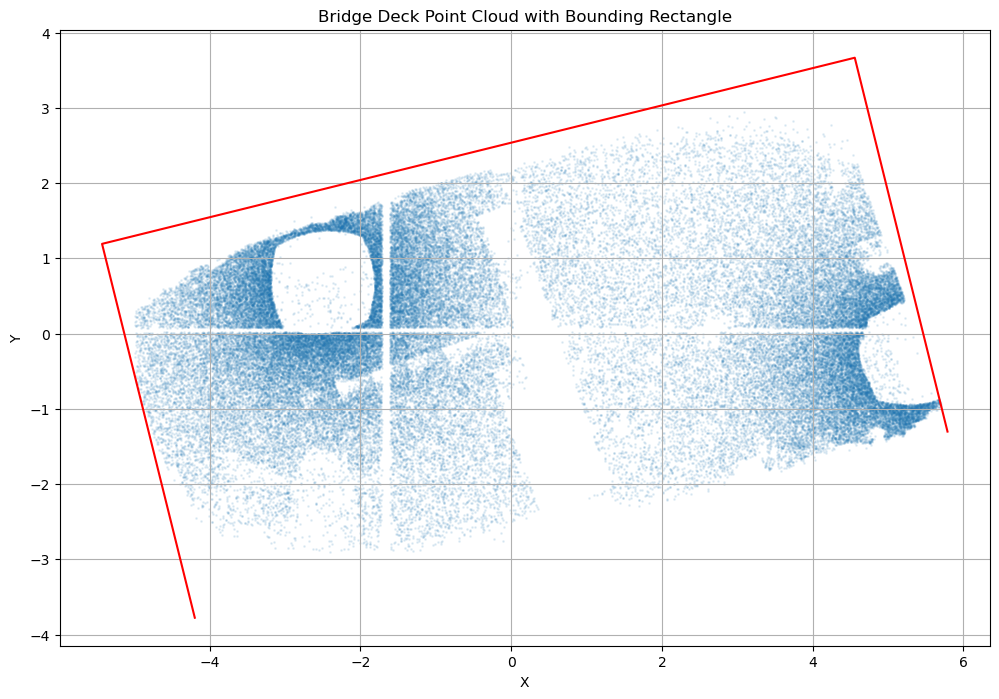

In [134]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull

def ransac_plane_fit(points, max_trials=2000, residual_threshold=0.1):
    ransac = RANSACRegressor(max_trials=max_trials, residual_threshold=residual_threshold, random_state=42)
    ransac.fit(points[:, :2], points[:, 2])
    inlier_mask = ransac.inlier_mask_
    return points[inlier_mask]

def project_to_plane(points):
    return points[:, :2]

def align_to_principal_axes(points):
    pca = PCA(n_components=2)
    pca.fit(points)
    return pca.transform(points)

def detect_and_trim_edges(points, percentile=2):
    x, y = points[:, 0], points[:, 1]
    x_density, x_bins = np.histogram(x, bins=100)
    y_density, y_bins = np.histogram(y, bins=100)
    
    x_threshold = np.percentile(x_density, percentile)
    y_threshold = np.percentile(y_density, percentile)
    
    x_indices = np.clip(np.digitize(x, x_bins[1:-1]) - 1, 0, len(x_density) - 1)
    y_indices = np.clip(np.digitize(y, y_bins[1:-1]) - 1, 0, len(y_density) - 1)
    
    x_mask = np.logical_and(x_density[x_indices] > x_threshold, x_density[x_indices] < np.max(x_density))
    y_mask = np.logical_and(y_density[y_indices] > y_threshold, y_density[y_indices] < np.max(y_density))
    
    return points[np.logical_and(x_mask, y_mask)]

def minimum_bounding_rectangle(points):
    hull_points = points[ConvexHull(points).vertices]
    edges = np.subtract.outer(hull_points, hull_points).reshape(-1, 2)
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, np.pi/2))
    angles = np.unique(angles)
    
    rotations = np.vstack([np.cos(angles), -np.sin(angles), 
                           np.sin(angles), np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))
    
    rot_points = np.dot(rotations, hull_points.T)
    
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)
    
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)
    
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]
    
    rval = np.array([
        np.dot([x1, y2], r),
        np.dot([x2, y2], r),
        np.dot([x2, y1], r),
        np.dot([x1, y1], r)
    ])
    
    return rval

def process_bridge_deck(points):
    # 只使用 x, y, z 坐标
    xyz_points = points[:, :3]
    
    # 1. 平面拟合和投影
    points_plane = ransac_plane_fit(xyz_points,2000,0.1)

    result = isolation_forest_outlier_removal(points_plane, contamination=0.1)

    result = project_to_plane(result)
    
    result = result

    # 2. 主方向对齐
    result = align_to_principal_axes(result)
    
    # 3. 边缘检测和修剪
    points_trimmed = detect_and_trim_edges(result)
    result= detect_and_trim_edges(result)

    # 4. 矩形拟合
    rect = minimum_bounding_rectangle(result)
    #rect = result

    # 计算长度和宽度
    #length, width = calculate_bridge_dimensions(rect)
    width = np.linalg.norm(rect[1] - rect[0])
    length = np.linalg.norm(rect[2] - rect[1])
    
    return max(width, length), min(width, length), points_trimmed, rect

def process_raw(points):
    # 只使用 x, y, z 坐标
    xyz_points = points[:, :3]
   
    result = project_to_plane(xyz_points)

    # 2. 主方向对齐
    result = align_to_principal_axes(result)
    
    # 3. 边缘检测和修剪
    points_trimmed = detect_and_trim_edges(result)
    result= detect_and_trim_edges(result)

    # 4. 矩形拟合
    rect = minimum_bounding_rectangle(result)

    # 计算长度和宽度
    #length, width = calculate_bridge_dimensions(rect)
    width = np.linalg.norm(rect[1] - rect[0])
    length = np.linalg.norm(rect[2] - rect[1])
    
    return max(width, length), min(width, length), points_trimmed, rect

deck_raw, deck_test = load_data('Bridge4_1')

start_time = time.time()

result = deck_test

# 使用函数
#length_raw, width_raw = calculate_bridge_dimensions(deck_raw)
length_raw, width_raw, cleaned_points, bounding_rect = process_raw(deck_raw)
length, width, cleaned_points, bounding_rect = process_bridge_deck(deck_test)

print(f"原始的桥板长度: {length_raw:.2f}")
print(f"原始的桥板宽度: {width_raw:.2f}")

print(f"估计的桥板长度: {length:.2f}")
print(f"估计的桥板宽度: {width:.2f}")

end_time = time.time()
# 可视化
print(f"Time: {end_time - start_time:.2f} s")
#plot_deck(deck_test,'RANSAC')

# 可视化
plt.figure(figsize=(12, 8))
plt.scatter(cleaned_points[:, 0], cleaned_points[:, 1], alpha=0.1, s=1)
plt.plot(bounding_rect[:, 0], bounding_rect[:, 1], 'r-')
plt.title('Bridge Deck Point Cloud with Bounding Rectangle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()


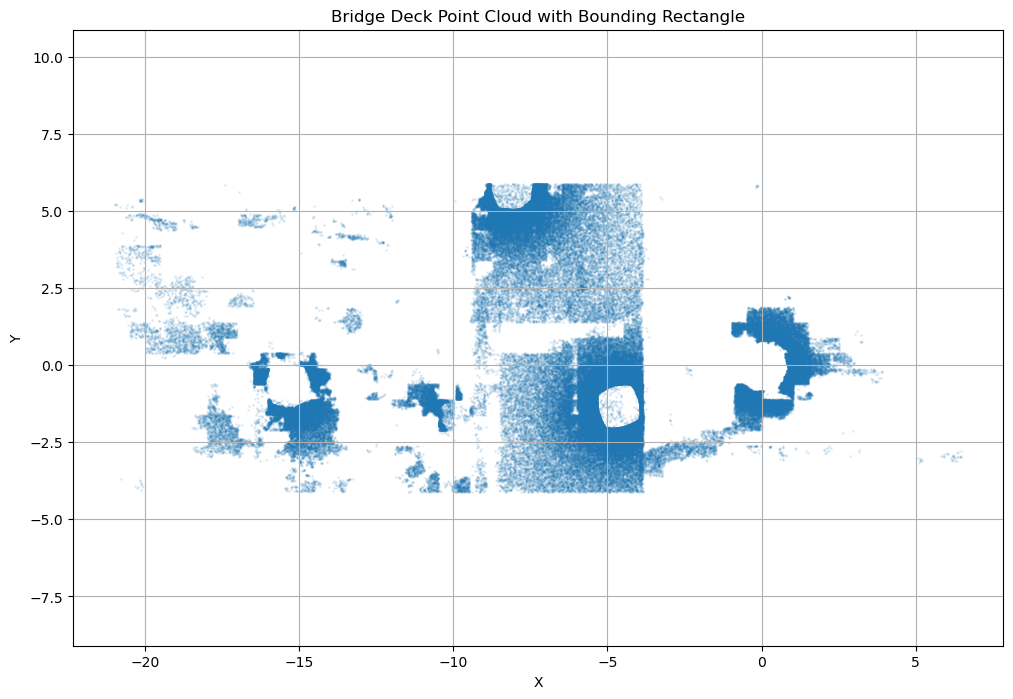

In [137]:
# 可视化
plt.figure(figsize=(12, 8))
plt.scatter(deck_test[:, 0], deck_test[:, 1], alpha=0.1, s=1)
#plt.plot(bounding_rect[:, 0], bounding_rect[:, 1], 'r-')
plt.title('Bridge Deck Point Cloud with Bounding Rectangle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True)
plt.show()


In [23]:
# 假设 ransac_inliers 是RANSAC提取的平面内点
width, length = calculate_bridge_dimensions(deck_raw)
print(f"估计的桥板宽度: {width:.2f}")
print(f"估计的桥板长度: {length:.2f}")

IndexError: index -1 is out of bounds for axis 0 with size 0

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def calculate_bridge_dimensions(points, percentile=99):
    # 分离x, y, z坐标
    x = points[:, 0]
    y = points[:, 1]

    # 计算宽度（x方向）
    x_sorted = np.sort(x)
    x_min = np.percentile(x_sorted, 100 - percentile)
    x_max = np.percentile(x_sorted, percentile)
    
    width = np.abs(x_max - x_min)

    # 计算长度（y方向）
    y_sorted = np.sort(y)
    y_min = np.percentile(y_sorted, 100 - percentile)
    y_max = np.percentile(y_sorted, percentile)
    
    length = np.abs(y_max - y_min)

    return width, length

def visualize_bridge(points, width, length):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o', s=1)
    
    # 绘制估计的边界框
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
    z_min, z_max = np.min(points[:, 2]), np.max(points[:, 2])
    
    # 创建边界框的顶点
    vertices = [
        [x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_max, z_min], [x_min, y_max, z_min],
        [x_min, y_min, z_max], [x_max, y_min, z_max], [x_max, y_max, z_max], [x_min, y_max, z_max]
    ]
    
    # 定义边界框的边
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # 底面
        [4, 5], [5, 6], [6, 7], [7, 4],  # 顶面
        [0, 4], [1, 5], [2, 6], [3, 7]   # 连接顶面和底面的边
    ]
    
    # 绘制边界框
    for edge in edges:
        ax.plot3D(*zip(vertices[edge[0]], vertices[edge[1]]), color='r')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Bridge Dimensions: Width = {width:.2f}, Length = {length:.2f}')
    plt.show()

# 假设 ransac_inliers 是RANSAC提取的平面内点
width, length = calculate_bridge_dimensions(result)
print(f"估计的桥板宽度: {width:.2f}")
print(f"估计的桥板长度: {length:.2f}")

# 可视化结果
#visualize_bridge(result, width, length)


估计的桥板宽度: 4.01
估计的桥板长度: 1.87


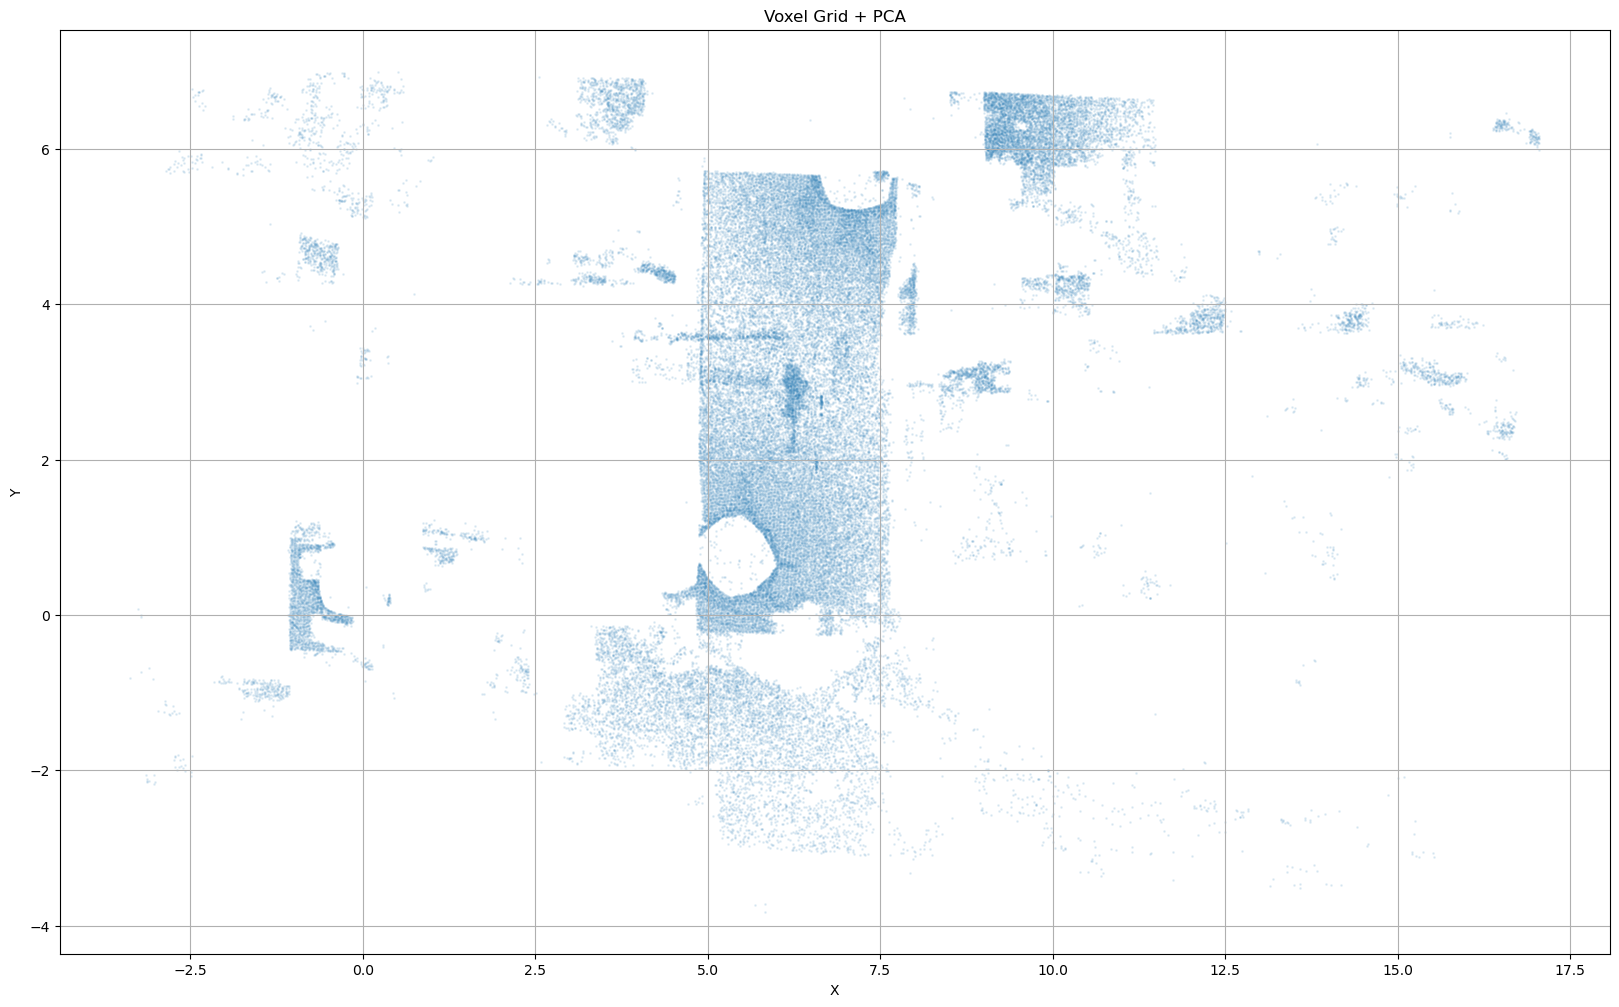

In [70]:
from sklearn.decomposition import PCA

def voxel_grid_pca(data, voxel_size=0.1):
    
    bridge_points = data[:, :3]
    
    # 体素网格滤波
    voxel_coords = np.floor(bridge_points / voxel_size).astype(int)
    _, unique_indices = np.unique(voxel_coords, axis=0, return_index=True)
    filtered_points = bridge_points[unique_indices]
    
    # PCA
    pca = PCA(n_components=3)
    pca.fit(filtered_points)
    
    # 投影到主平面
    projected_points = pca.transform(filtered_points)
    projected_points[:, 2] = 0  # 将第三个主成分设为0
    result = pca.inverse_transform(projected_points)
    
    return result

# 使用示例
result = voxel_grid_pca(deck_test,0.02)

# 可视化
plot_deck(result,'Voxel Grid + PCA')


In [29]:
#ground ture deck

start_time = time.time()
# 计算 x 和 y 方向的最大跨度
x_min, x_max = np.min(deck_coords[:, 0]), np.max(deck_coords[:, 0])
y_min, y_max = np.min(deck_coords[:, 1]), np.max(deck_coords[:, 1])

bridge_length = y_max - y_min  # 假设桥的长度沿 y 轴
bridge_width = x_max - x_min   # 假设桥的宽度沿 x 轴

end_time = time.time()

print(f"Estimated bridge length: {bridge_length:.2f}")
print(f"Estimated bridge width: {bridge_width:.2f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

Estimated bridge length: 10.00
Estimated bridge width: 27.42
Time taken: 0.00 seconds


Estimated bridge length (PCA): 12.86
Estimated bridge width (PCA): 10.16
PCA time taken: 0.01 seconds


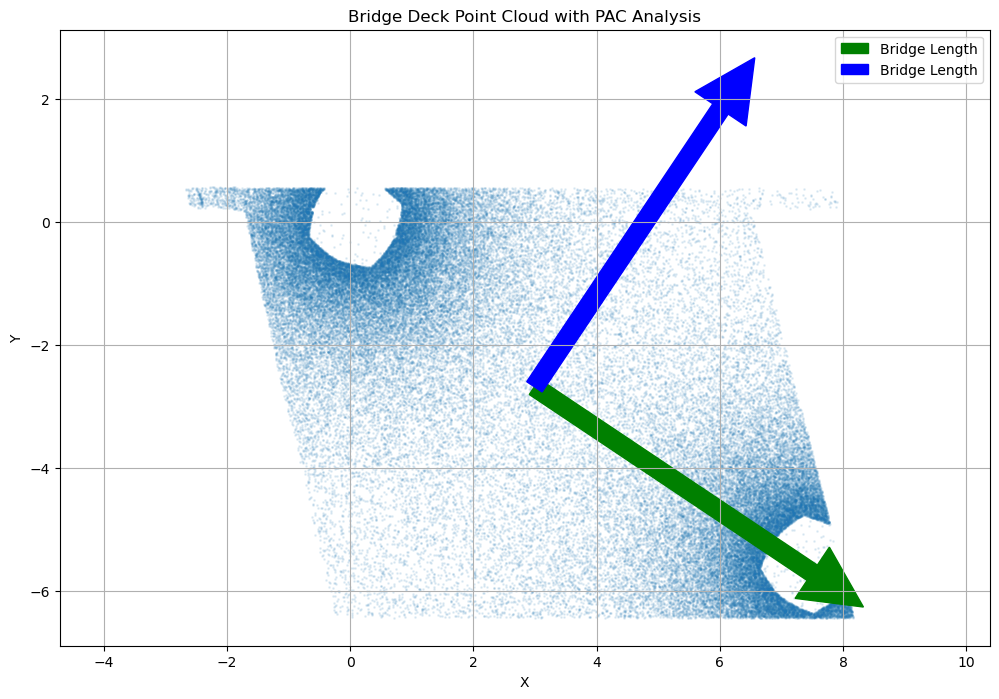

In [96]:
# 使用PCA方法进行比较

def WL_PCA(data):
    from sklearn.decomposition import PCA
    pca_start_time = time.time()
    pca = PCA(n_components=2)
    pca.fit(data)
    # 将数据投影到主成分上
    projected_data = pca.transform(data)
    # 计算PCA方法的长度和宽度
    pca_length = np.max(projected_data[:, 0]) - np.min(projected_data[:, 0])
    pca_width = np.max(projected_data[:, 1]) - np.min(projected_data[:, 1])
    pca_end_time = time.time()
    print(f"Estimated bridge length (PCA): {pca_length:.2f}")
    print(f"Estimated bridge width (PCA): {pca_width:.2f}")
    print(f"PCA time taken: {pca_end_time - pca_start_time:.2f} seconds")
    # 可视化
    plt.figure(figsize=(12, 8))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1, s=1)
    plt.title('Bridge Deck (Top View)')
    plt.xlabel('X')
    plt.ylabel('Y')
    # 绘制主方向
    mean = np.mean(data, axis=0)
    eigen_vec = pca.components_[0]
    eigen_vec = eigen_vec * pca_length / 2  # 缩放箭头长度

    eigen_vec2 = pca.components_[1]
    eigen_vec2 = eigen_vec2 * pca_length / 2  # 缩放箭头长度

    plt.arrow(mean[0], mean[1], eigen_vec[0], eigen_vec[1], 
            color='g', width=0.3, head_width=1, head_length=1, 
            length_includes_head=True, label='Bridge Length')

    plt.arrow(mean[0], mean[1], eigen_vec2[0], eigen_vec2[1], 
            color='b', width=0.3, head_width=1, head_length=1, 
            length_includes_head=True, label='Bridge Length')


    plt.title('Bridge Deck Point Cloud with PAC Analysis')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()
    return pca_length, pca_width

pca_length, pca_width = WL_PCA(deck_raw)





In [14]:
# 计算点云的协方差矩阵
cov_matrix = np.cov(deck_coords.T)

# 计算协方差矩阵的特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# 找到最大特征值对应的特征向量
max_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

# 将所有点投影到这个方向上
projections = np.dot(deck_coords, max_eigenvector)

# 计算投影的最大和最小值之差作为桥长
bridge_length = np.max(projections) - np.min(projections)

# 计算垂直于主方向的向量
perpendicular_vector = np.array([-max_eigenvector[1], max_eigenvector[0]])

# 将所有点投影到垂直方向上
perp_projections = np.dot(deck_coords, perpendicular_vector)

# 计算垂直投影的最大和最小值之差作为桥宽
bridge_width = np.max(perp_projections) - np.min(perp_projections)

print(f"Estimated bridge length (Covariance): {bridge_length:.2f}")
print(f"Estimated bridge width (Covariance): {bridge_width:.2f}")

Estimated bridge length (Covariance): 10.82
Estimated bridge width (Covariance): 8.14


In [15]:
# 计算边界框
min_coords = np.min(deck_coords, axis=0)
max_coords = np.max(deck_coords, axis=0)

# 计算对角线长度（作为桥长的估计）
diagonal_length = np.linalg.norm(max_coords - min_coords)

# 计算边界框的宽度和长度
width = max_coords[1] - min_coords[1]
length = max_coords[0] - min_coords[0]

print(f"Estimated bridge length (diagonal): {diagonal_length:.2f}")
print(f"Estimated bridge length (bounding box): {length:.2f}")
print(f"Estimated bridge width (bounding box): {width:.2f}")

Estimated bridge length (diagonal): 11.45
Estimated bridge length (bounding box): 5.58
Estimated bridge width (bounding box): 10.00


Estimated bridge length (RANSAC): 27.42
Estimated bridge width (RANSAC): 10.00
Time taken: 0.04 seconds


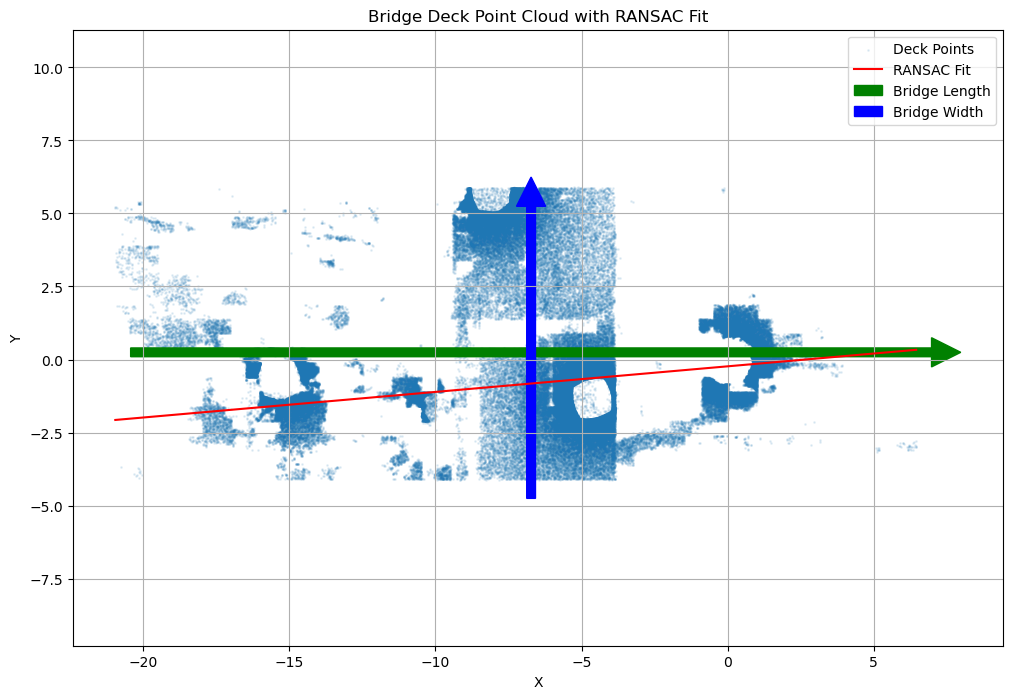

In [47]:
from sklearn.linear_model import RANSACRegressor
import time

start_time = time.time()


# 使用RANSAC拟合直线
ransac = RANSACRegressor()
ransac.fit(deck_coords[:, 0].reshape(-1, 1), deck_coords[:, 1])

# 获取RANSAC模型的方向向量
slope = ransac.estimator_.coef_[0]
angle = np.arctan(slope)

# 判断主方向是更接近X轴还是Y轴
if abs(angle) < np.pi/4:  # 更接近X轴
    direction_vector = np.array([1, 0])
    perpendicular_vector = np.array([0, 1])
else:  # 更接近Y轴
    direction_vector = np.array([0, 1])
    perpendicular_vector = np.array([1, 0])

# 将所有点投影到主方向上
projections = np.dot(deck_coords, direction_vector)

# 计算桥长（投影的最大和最小值之差）
bridge_length = np.max(projections) - np.min(projections)

# 将所有点投影到垂直方向上
perp_projections = np.dot(deck_coords, perpendicular_vector)

# 计算桥宽（垂直投影的最大和最小值之差）
bridge_width = np.max(perp_projections) - np.min(perp_projections)

end_time = time.time()

print(f"Estimated bridge length (RANSAC): {bridge_length:.2f}")
print(f"Estimated bridge width (RANSAC): {bridge_width:.2f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")


# 可视化
plt.figure(figsize=(12, 8))
plt.scatter(deck_coords[:, 0], deck_coords[:, 1], s=1, alpha=0.1, label='Deck Points')

# 计算RANSAC直线的端点
x_min, x_max = np.min(deck_coords[:, 0]), np.max(deck_coords[:, 0])
y_min = ransac.predict([[x_min]])[0]
y_max = ransac.predict([[x_max]])[0]

# 绘制RANSAC拟合的直线
plt.plot([x_min, x_max], [y_min, y_max], 'r-', label='RANSAC Fit')

# 计算桥长和桥宽的端点
center = np.mean(deck_coords, axis=0)
length_vector = direction_vector * bridge_length / 2
width_vector = perpendicular_vector * bridge_width / 2

# 绘制桥长
plt.arrow(center[0] - length_vector[0], center[1] - length_vector[1],
          length_vector[0] * 2, length_vector[1] * 2,
          color='g', width=0.3, head_width=1, head_length=1, label='Bridge Length')

# 绘制桥宽
plt.arrow(center[0] - width_vector[0], center[1] - width_vector[1],
          width_vector[0] * 2, width_vector[1] * 2,
          color='b', width=0.3, head_width=1, head_length=1, label='Bridge Width')

plt.title('Bridge Deck Point Cloud with RANSAC Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)

Estimated bridge length: 20.32
Estimated bridge width: 9.61
Time taken: 0.05 seconds


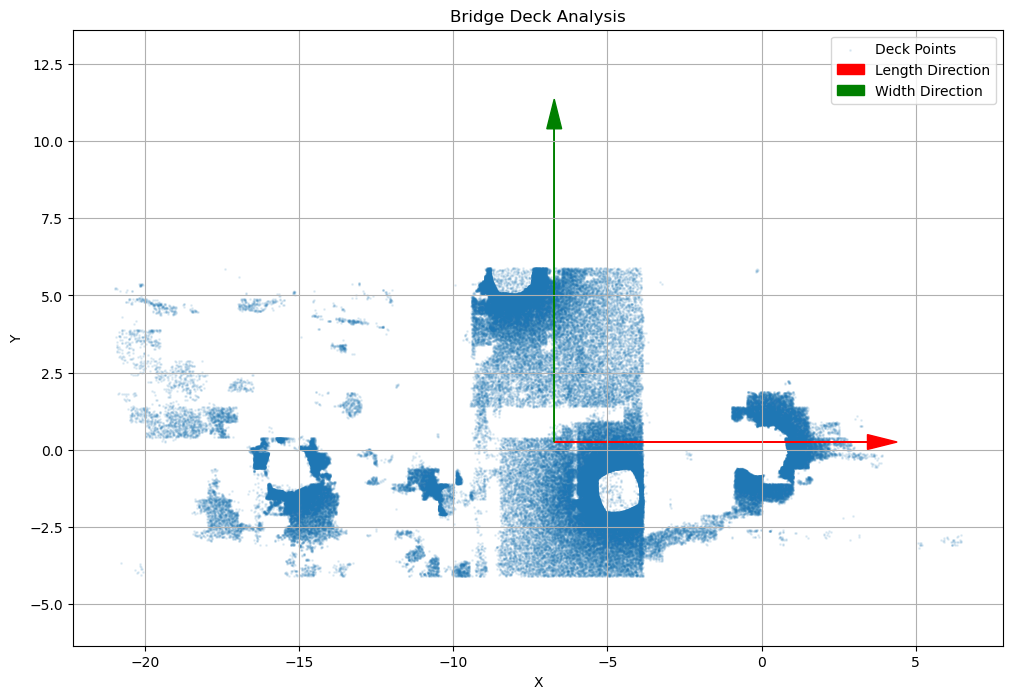

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

def calculate_bridge_dimensions(deck_coords):
    start_time = time.time()
    # 步骤1: 使用椭圆包络去除离群值
    #outlier_detector = EllipticEnvelope(contamination=0.1, random_state=42)
    #inlier_mask = outlier_detector.fit_predict(deck_coords) == 1
    filtered_coords = deck_coords
    

    # 步骤2: 使用PCA进行初步方向估计
    pca = PCA(n_components=2)
    pca.fit(filtered_coords)
    
    # 步骤3: 使用RANSAC拟合主方向
    ransac = RANSACRegressor(random_state=42)
    x = filtered_coords[:, 0].reshape(-1, 1)
    y = filtered_coords[:, 1]
    ransac.fit(x, y)
    
    # 步骤4: 计算主方向向量
    angle = np.arctan(ransac.estimator_.coef_[0])
    main_direction = np.array([np.cos(angle), np.sin(angle)])
    
    # 步骤5: 确保主方向更接近x轴或y轴
    if abs(main_direction[0]) < abs(main_direction[1]):
        main_direction = np.array([0, 1])
    else:
        main_direction = np.array([1, 0])
    
    # 步骤6: 计算垂直方向
    perpendicular_direction = np.array([-main_direction[1], main_direction[0]])
    
    # 步骤7: 计算桥长和桥宽
    projections_main = np.dot(filtered_coords, main_direction)
    projections_perp = np.dot(filtered_coords, perpendicular_direction)
    
    bridge_length = np.percentile(projections_main, 99) - np.percentile(projections_main, 1)
    bridge_width = np.percentile(projections_perp, 99) - np.percentile(projections_perp, 1)
    
    end_time = time.time()
    
    time_taken = end_time - start_time
    
    return bridge_length, bridge_width, main_direction, perpendicular_direction, filtered_coords, time_taken

# 假设deck_coords是一个numpy数组，形状为(n, 2)
bridge_length, bridge_width, main_direction, perpendicular_direction, filtered_coords, time_taken = calculate_bridge_dimensions(deck_coords)

print(f"Estimated bridge length: {bridge_length:.2f}")
print(f"Estimated bridge width: {bridge_width:.2f}")
print(f"Time taken: {time_taken:.2f} seconds")

# 可视化结果
plt.figure(figsize=(12, 8))
plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], s=1, alpha=0.1, label='Deck Points')

# 绘制主方向和垂直方向
mean = np.mean(filtered_coords, axis=0)
for direction, color, label in zip([main_direction, perpendicular_direction], ['r', 'g'], ['Length', 'Width']):
    plt.arrow(mean[0], mean[1], direction[0]*bridge_length/2, direction[1]*bridge_length/2, 
              color=color, head_width=bridge_width/20, head_length=bridge_width/10, 
              label=f"{label} Direction")

plt.title('Bridge Deck Analysis')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()




Total points: 892875
Deck points_raw: (97462, 7)
Deck points_test: (147068, 7)
Estimated bridge length: 9.70
Estimated bridge width: 5.38
Time taken: 0.03 seconds


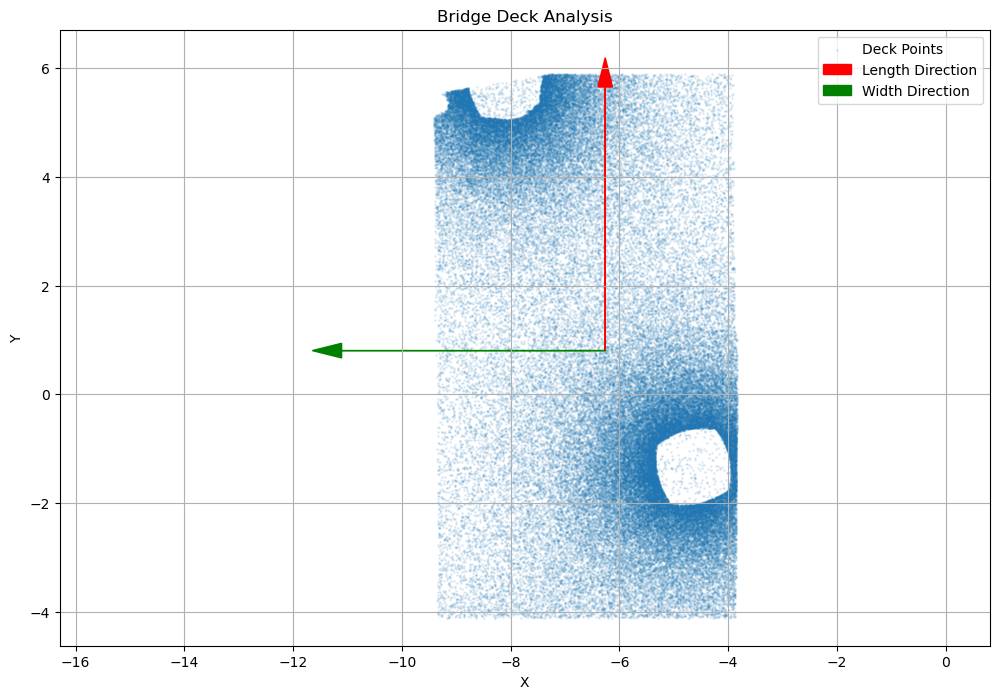

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

def calculate_bridge_dimensions(deck_coords):
    start_time = time.time()
    # 步骤1: 使用椭圆包络去除离群值
    #outlier_detector = EllipticEnvelope(contamination=0.1, random_state=42)
    #inlier_mask = outlier_detector.fit_predict(deck_coords) == 1
    filtered_coords = deck_coords
    

    # 步骤2: 使用PCA进行初步方向估计
    pca = PCA(n_components=2)
    pca.fit(filtered_coords)
    
    # 步骤3: 使用RANSAC拟合主方向
    ransac = RANSACRegressor(random_state=42)
    x = filtered_coords[:, 0].reshape(-1, 1)
    y = filtered_coords[:, 1]
    ransac.fit(x, y)
    
    # 步骤4: 计算主方向向量
    angle = np.arctan(ransac.estimator_.coef_[0])
    main_direction = np.array([np.cos(angle), np.sin(angle)])
    
    # 步骤5: 确保主方向更接近x轴或y轴
    if abs(main_direction[0]) < abs(main_direction[1]):
        main_direction = np.array([0, 1])
    else:
        main_direction = np.array([1, 0])
    
    # 步骤6: 计算垂直方向
    perpendicular_direction = np.array([-main_direction[1], main_direction[0]])
    
    # 步骤7: 计算桥长和桥宽
    projections_main = np.dot(filtered_coords, main_direction)
    projections_perp = np.dot(filtered_coords, perpendicular_direction)
    
    bridge_length = np.percentile(projections_main, 99) - np.percentile(projections_main, 1)
    bridge_width = np.percentile(projections_perp, 99) - np.percentile(projections_perp, 1)
    
    end_time = time.time()
    
    time_taken = end_time - start_time
    
    return bridge_length, bridge_width, main_direction, perpendicular_direction, filtered_coords, time_taken


# 假设deck_coords是一个numpy数组，形状为(n, 2)
deck_raw, deck_test = load_data('Bridge4_1')
deck_raw_coords = deck_raw[:, :2]
deck_test_coords = deck_test[:, :2]
bridge_length, bridge_width, main_direction, perpendicular_direction, filtered_coords, time_taken = calculate_bridge_dimensions(deck_raw_coords)

print(f"Estimated bridge length: {bridge_length:.2f}")
print(f"Estimated bridge width: {bridge_width:.2f}")
print(f"Time taken: {time_taken:.2f} seconds")

# 可视化结果
plt.figure(figsize=(12, 8))
plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], s=1, alpha=0.1, label='Deck Points')

# 绘制主方向和垂直方向
mean = np.mean(filtered_coords, axis=0)
for direction, color, label in zip([main_direction, perpendicular_direction], ['r', 'g'], ['Length', 'Width']):
    plt.arrow(mean[0], mean[1], direction[0]*bridge_length/2, direction[1]*bridge_length/2, 
              color=color, head_width=bridge_width/20, head_length=bridge_width/10, 
              label=f"{label} Direction")

plt.title('Bridge Deck Analysis')
plt.xlabel('X')

plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()
